In [926]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles , make_moons

In [927]:
n_samples = 1000
X , y = make_circles(n_samples, noise=0.03,  random_state=43)

In [928]:
X.shape , y.shape

((1000, 2), (1000,))

In [929]:
import pandas as pd

df = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"Y":y})
df.head(5)

,X1,X2,Y
0,-0.124570,-0.785914,1
1,0.772370,-0.158252,1
2,-0.657123,0.768114,0
3,0.794009,0.051699,1
4,-0.642243,0.361384,1


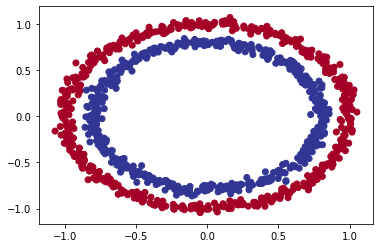

In [930]:
plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.RdYlBu)

In [931]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [932]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32).unsqueeze(dim = 1)
split_percentage = int(0.8*len(X))
X_train , y_train = X[:split_percentage], y[:split_percentage]
X_test,y_test = X[split_percentage:], y[split_percentage:]

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print(y_train.shape)

torch.Size([800, 1])


In [933]:
class circle_model_v0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,out_features=10)
        self.linear_layer2 = nn.Linear(in_features=10,out_features=1)
        
    def  forward(self,x : torch.tensor) -> torch.Tensor:
        return self.linear_layer2(self.linear_layer1(x))
    
def plotting(x,y,predictions = None):
    plt.scatter(x,y,c = "r")
    if predictions is not None:
        plt.scatter(x,predictions,c = "b")



In [934]:
model = circle_model_v0()
model.to(device)

circle_model_v0(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=1, bias=True)
)

In [935]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997]], requires_grad=True),
 Parameter containing:
 tensor([0.0850], requires_grad=True)]

In [936]:
model.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997]])),
             ('linear_layer2.bias', tensor([0.0850]))])

In [937]:
loss = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.01)

In [938]:
def accuracy_fn(y_pred, y_true):
   correct = torch.eq(y_true,y_pred).sum().item()
   acc = (correct/len(y_pred)) * 100
   return acc

In [939]:
torch.manual_seed(42)
epochs  = 100
epoch_set = []
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    model.train()
    y_preds = model(X_train)
  
    y_preds1 = torch.round(torch.sigmoid(y_preds))
    loss1 = loss(y_preds,y_train)
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    model.eval()
    epoch_set.append(epoch)
    train_loss.append(loss1.item())
    train_acc = accuracy_fn(y_preds1,y_train)
    train_accuracy.append(train_acc)
    with torch.inference_mode():
        y_logits_test = model(X_test)
        y_preds2 = torch.round(torch.sigmoid(y_logits_test))
        loss2 = loss(y_logits_test,y_test)
        test_loss.append(loss2.item())
        test_acc = accuracy_fn(y_preds2,y_test)
        test_accuracy.append(test_acc)
    print("Epoch: {}, Train Loss: {}, Train acc: {} , Test Loss: {} , Test acc: {}".format(epoch,loss1.item(),train_acc,loss2.item(),test_acc))
    
    
    
    

Epoch: 0, Train Loss: 0.6966847777366638, Train acc: 50.625 , Test Loss: 0.7125838994979858 , Test acc: 42.5
Epoch: 1, Train Loss: 0.6950201392173767, Train acc: 51.24999999999999 , Test Loss: 0.7080031037330627 , Test acc: 43.0
Epoch: 2, Train Loss: 0.694009006023407, Train acc: 51.625 , Test Loss: 0.7045732140541077 , Test acc: 43.0
Epoch: 3, Train Loss: 0.6933581829071045, Train acc: 51.625 , Test Loss: 0.7020230889320374 , Test acc: 42.5
Epoch: 4, Train Loss: 0.692897617816925, Train acc: 52.125 , Test Loss: 0.7001781463623047 , Test acc: 43.5
Epoch: 5, Train Loss: 0.6925969123840332, Train acc: 52.125 , Test Loss: 0.6989381909370422 , Test acc: 41.5
Epoch: 6, Train Loss: 0.6924552917480469, Train acc: 51.87500000000001 , Test Loss: 0.6982014179229736 , Test acc: 40.5
Epoch: 7, Train Loss: 0.692465603351593, Train acc: 51.0 , Test Loss: 0.6978212594985962 , Test acc: 41.5
Epoch: 8, Train Loss: 0.6925933957099915, Train acc: 49.25 , Test Loss: 0.6976105570793152 , Test acc: 40.0
Epo

In [940]:
y_preds_test = torch.sigmoid(y_logits_test)
y_preds_test = torch.round(y_preds_test)
print(y_preds_test,y_logits_test)
accuracy_fn(y_preds_test, y_test)

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

41.5

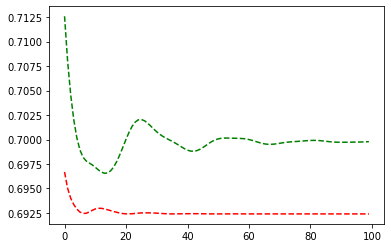

In [941]:
def plot_epoch_loss(epoch,loss,color):
    plt.plot(epoch,loss,color)
plot_epoch_loss(epoch_set,test_loss,color = "g--")
plot_epoch_loss(epoch_set,train_loss,color = "r--")

In [942]:
model.eval()
with torch.inference_mode():
    y_p = model(X_test)


In [943]:
torch.save(model.state_dict(),"models/circle_model_v0.pth")

In [944]:
# torch.cuda.manual_seed(42) for gpu

BCELOSS with logits come with sigmoid we dont want to put in after nn.linear_layr

but bceloss we want to use loss(torch.sigmoid(y_logits))

In [945]:
import requests
from pathlib import Path

if Path("helper.py").is_file():
    print("file existed")
else:
    print("Downloading from github repo  --  ")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper.py", "wb") as f:
        f.write(request.content)

file existed


torch.Size([1, 800, 2]) torch.Size([800])


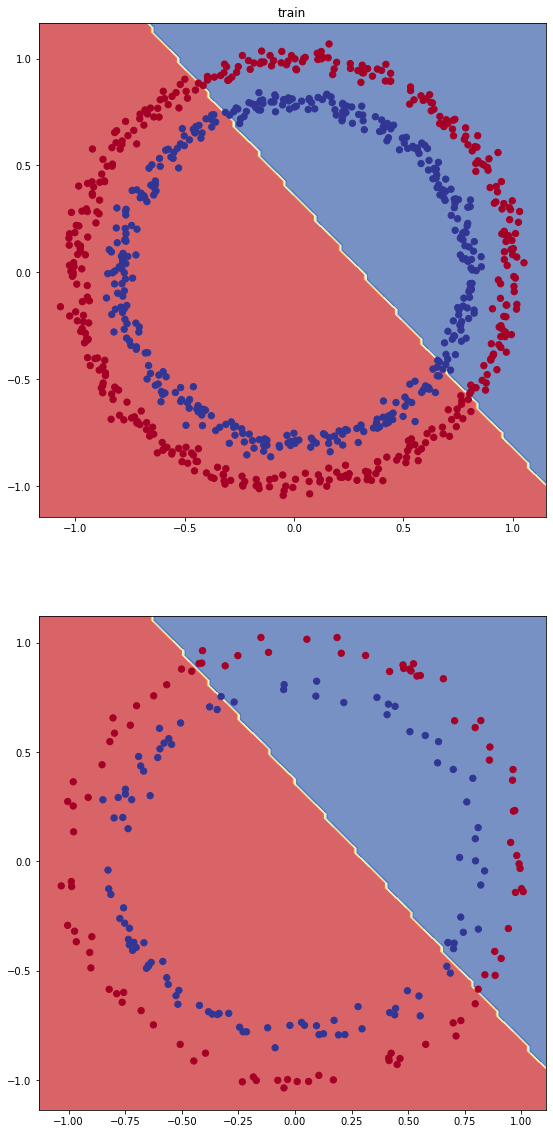

In [946]:
from helper import plot_decision_boundary,plot_predictions
print(X_train.unsqueeze(dim = 0).shape , y_train.squeeze(dim = 1).shape)
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("train")
plot_decision_boundary(model,X=X_train,y = y_train.squeeze(dim = 1))
plt.subplot(2,2,3)
plot_decision_boundary(model,X = X_test,y = y_test.squeeze(dim = 1))
 


Improve model's performance  --

1. Add more layers  - give chance to model to learn pattern
2. Add more hidden units  -  5 to 10 to 20
3. change activation function
4. change loss function
5. change optimizer function
6. Fit for longer i mean epochs
7. change learning rate


we use torch.utils.tensorboard

WE can use Sequential also 

model1 = nn.Sequential(

    nn.Linear(3,128),

    nn.ReLU(),

    nn.Linear(128,64),

    nn.ReLU(),

    nn.Linear(64,2)
    
)

In [947]:
class circle_model_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,out_features=10)
        self.linear_layer2 = nn.Linear(in_features=10,out_features=10)
        self.linear_layer3 = nn.Linear(in_features=10,out_features=1)
        
    def  forward(self,x : torch.tensor) -> torch.Tensor:
        return self.linear_layer3(self.linear_layer2(self.linear_layer1(x)))

In [948]:
model_v1 = circle_model_v1()
model_v1.state_dict()
model_v1.to(device)

circle_model_v1(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [949]:
loss_v1 = torch.nn.BCEWithLogitsLoss()
optimizer_v1 = torch.optim.SGD(model_v1.parameters(), lr=0.001)

In [950]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

epoch_set_v1 = []
train_loss_v1 = []
test_loss_v1 = []
train_accuracy_v1 = []
test_accuracy_v1 = []
for epoch in range(epochs):
    model_v1.train()
    y_preds_v1 = model_v1(X_train)
  
    y_preds1_v1 = torch.round(torch.sigmoid(y_preds_v1))
    loss1_v1 = loss_v1(y_preds_v1,y_train)
    optimizer_v1.zero_grad()
    loss1_v1.backward()
    optimizer_v1.step()
    model_v1.eval()
    epoch_set_v1.append(epoch)
    train_loss_v1.append(loss1_v1.item())
    train_acc_v1 = accuracy_fn(y_preds1_v1,y_train)
    train_accuracy_v1.append(train_acc_v1)
    with torch.inference_mode():
        y_logits_test_v1 = model_v1(X_test)
        y_preds2_v1 = torch.round(torch.sigmoid(y_logits_test_v1))
        loss2_v1 = loss(y_logits_test_v1,y_test)
        test_loss_v1.append(loss2_v1.item())
        test_acc_v1 = accuracy_fn(y_preds2_v1,y_test)
        test_accuracy_v1.append(test_acc_v1)
    print("Epoch: {}, Train Loss: {}, Train acc: {} , Test Loss: {} , Test acc: {}".format(epoch,loss1_v1.item(),train_acc_v1,loss2_v1.item(),test_acc_v1))
    
    
    
    

Epoch: 0, Train Loss: 0.6947312951087952, Train acc: 49.5 , Test Loss: 0.6898895502090454 , Test acc: 56.49999999999999
Epoch: 1, Train Loss: 0.6947304010391235, Train acc: 49.625 , Test Loss: 0.68989098072052 , Test acc: 56.49999999999999
Epoch: 2, Train Loss: 0.6947293877601624, Train acc: 49.625 , Test Loss: 0.6898924112319946 , Test acc: 56.49999999999999
Epoch: 3, Train Loss: 0.6947283744812012, Train acc: 49.625 , Test Loss: 0.689893901348114 , Test acc: 56.49999999999999
Epoch: 4, Train Loss: 0.6947274804115295, Train acc: 49.625 , Test Loss: 0.6898953914642334 , Test acc: 56.49999999999999
Epoch: 5, Train Loss: 0.6947264671325684, Train acc: 49.625 , Test Loss: 0.6898967623710632 , Test acc: 56.49999999999999
Epoch: 6, Train Loss: 0.6947255730628967, Train acc: 49.625 , Test Loss: 0.6898982524871826 , Test acc: 56.49999999999999
Epoch: 7, Train Loss: 0.6947246789932251, Train acc: 49.625 , Test Loss: 0.6898996829986572 , Test acc: 56.49999999999999
Epoch: 8, Train Loss: 0.69472

torch.Size([1, 800, 2]) torch.Size([800])


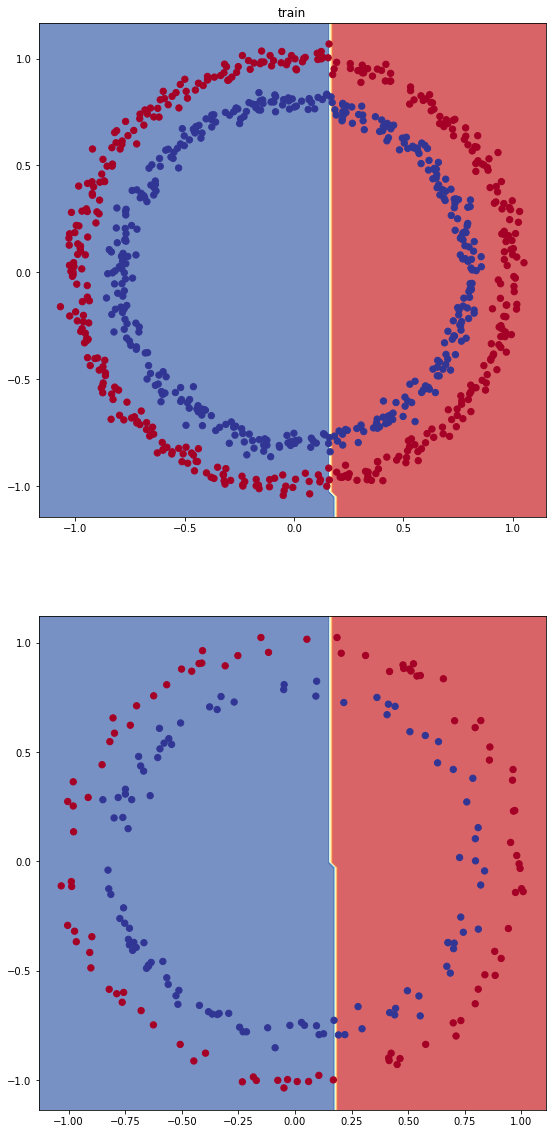

In [951]:
from helper import plot_decision_boundary,plot_predictions
print(X_train.unsqueeze(dim = 0).shape , y_train.squeeze(dim = 1).shape)
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("train")
plot_decision_boundary(model_v1,X=X_train,y = y_train.squeeze(dim = 1))
plt.subplot(2,2,3)
plot_decision_boundary(model_v1,X = X_test,y = y_test.squeeze(dim = 1))
 


MODEL FOR NONE LINEAR DATA

In [952]:
class circle_model_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,out_features=20)
        self.linear_layer2 = nn.Linear(in_features=20,out_features=15)
        self.linear_layer4 = nn.Linear(in_features=15,out_features=10)
        self.linear_layer3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()
        
    def  forward(self,x : torch.tensor) -> torch.Tensor:
        return self.linear_layer3(self.relu(self.linear_layer4(self.relu(self.linear_layer2(self.relu(self.linear_layer1(x)))))))

In [953]:
model_v2 = circle_model_v2()
model_v2.state_dict()
model_v2.to(device)

circle_model_v2(
  (linear_layer1): Linear(in_features=2, out_features=20, bias=True)
  (linear_layer2): Linear(in_features=20, out_features=15, bias=True)
  (linear_layer4): Linear(in_features=15, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [954]:
loss_v2 = torch.nn.BCEWithLogitsLoss()
optimizer_v2 = torch.optim.Adam(model_v2.parameters(), lr=0.001)

In [955]:
    
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 500

epoch_set_v2 = []
train_loss_v2 = []
test_loss_v2 = []
train_accuracy_v2 = []
test_accuracy_v2 = []
for epoch in range(epochs):
    model_v2.train()
    y_preds_v2 = model_v2(X_train)
  
    y_preds1_v2 = torch.round(torch.sigmoid(y_preds_v2))
    loss1_v2 = loss_v2(y_preds_v2,y_train)
    optimizer_v2.zero_grad()
    loss1_v2.backward()
    optimizer_v2.step()
    model_v2.eval()
    epoch_set_v2.append(epoch)
    train_loss_v2.append(loss1_v2.item())
    train_acc_v2 = accuracy_fn(y_preds1_v2,y_train)
    train_accuracy_v2.append(train_acc_v2)
    with torch.inference_mode():
        y_logits_test_v2 = model_v2(X_test)
        y_preds2_v2 = torch.round(torch.sigmoid(y_logits_test_v2))
        loss2_v2 = loss_v2(y_logits_test_v2,y_test)
        test_loss_v2.append(loss2_v2.item())
        test_acc_v2 = accuracy_fn(y_preds2_v2,y_test)
        test_accuracy_v2.append(test_acc_v2)
    print("Epoch: {}, Train Loss: {}, Train acc: {} , Test Loss: {} , Test acc: {}".format(epoch,loss1_v2.item(),train_acc_v2,loss2_v2.item(),test_acc_v2))
    
    
    
    

Epoch: 0, Train Loss: 0.6938787698745728, Train acc: 49.75 , Test Loss: 0.6902651786804199 , Test acc: 60.0
Epoch: 1, Train Loss: 0.6936999559402466, Train acc: 55.375 , Test Loss: 0.6902188062667847 , Test acc: 57.49999999999999
Epoch: 2, Train Loss: 0.693529486656189, Train acc: 55.00000000000001 , Test Loss: 0.6901812553405762 , Test acc: 59.0
Epoch: 3, Train Loss: 0.6933680176734924, Train acc: 52.125 , Test Loss: 0.6901533603668213 , Test acc: 58.5
Epoch: 4, Train Loss: 0.693217396736145, Train acc: 50.375 , Test Loss: 0.6901416182518005 , Test acc: 57.49999999999999
Epoch: 5, Train Loss: 0.6930891275405884, Train acc: 50.24999999999999 , Test Loss: 0.6901351809501648 , Test acc: 57.49999999999999
Epoch: 6, Train Loss: 0.6929783821105957, Train acc: 49.625 , Test Loss: 0.6901242136955261 , Test acc: 56.49999999999999
Epoch: 7, Train Loss: 0.6928707361221313, Train acc: 49.875 , Test Loss: 0.6901240348815918 , Test acc: 56.49999999999999
Epoch: 8, Train Loss: 0.6927721500396729, Tr

torch.Size([1, 800, 2]) torch.Size([800])


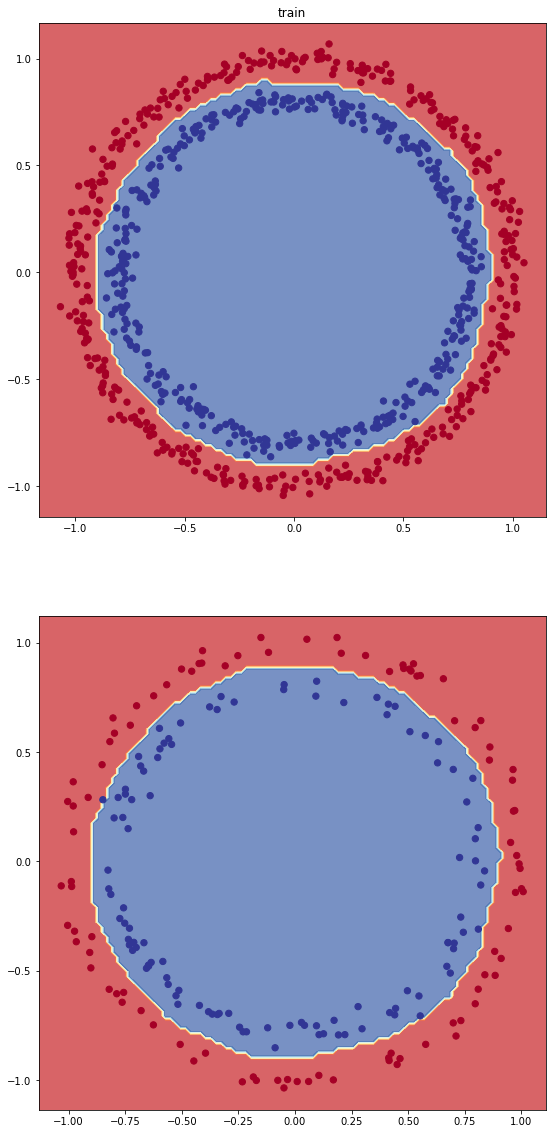

In [956]:
from helper import plot_decision_boundary,plot_predictions
print(X_train.unsqueeze(dim = 0).shape , y_train.squeeze(dim = 1).shape)
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("train")
plot_decision_boundary(model_v2,X=X_train,y = y_train.squeeze(dim = 1))
plt.subplot(2,2,3)
plot_decision_boundary(model_v2,X = X_test,y = y_test.squeeze(dim = 1))
 
